In [1]:
%load_ext rpy2.ipython
# Turning on in-IPy R capabilities

In [2]:
%%R
library(phyloseq)
library(vegan)
library(plyr)
library(dplyr)
library(ggplot2)

Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
#Creating the physeq object from our tree and biom table with taxonomic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../../../16S/SeqData/otu_table.tax.meta.biom", tree = "../../SeqData/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [4]:
%%R
Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [5]:
%%R
physeq.noSmall = subset_samples(physeq,sample_sums(physeq)>1500)

In [6]:
%%R
physeq = physeq.noSmall
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
physeq = transform_sample_counts(physeq, function(x) x / sum(x))
#physeq = subset_samples(physeq, Trtmt!="Heavy Fraction")
#physeq = subset_samples(physeq, Trtmt!="Kaolinite")
physeq = subset_samples(physeq, Trtmt!="Blank")
#physeq = subset_samples(physeq, Trtmt!="Quartz")
#physeq = subset_samples(physeq, Trtmt!="Ferrihydrite")
#physeq = subset_samples(physeq, Trtmt!="Soil")

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                    diff         lwr         upr     p adj
Heavy Fraction-Ferrihydrite  0.001427773 -0.13702773  0.13988327 0.9999998
Kaolinite-Ferrihydrite       0.137599317  0.03293680  0.24226184 0.0043241
Quartz-Ferrihydrite         -0.013345201 -0.09096500  0.06427460 0.9883776
Soil-Ferrihydrite           -0.162209557 -0.23849482 -0.08592429 0.0000017
Kaolinite-Heavy Fraction     0.136171544 -0.02082223  0.29316532 0.1182474
Quartz-Heavy Fraction       -0.014772974 -0.15519248  0.12564653 0.9982474
Soil-Heavy Fraction         -0.163637330 -0.30332357 -0.02395109 0.0140146
Quartz-Kaolinite            -0.150944518 -0.25819169 -0.04369735 0.0019294
Soil-Kaolinite              -0.299808874 -0.40609416 -0.19352358 0.0000000
Soil-Quartz                 -0.148864356 -0.22865880 -0.06906991 0.0000247



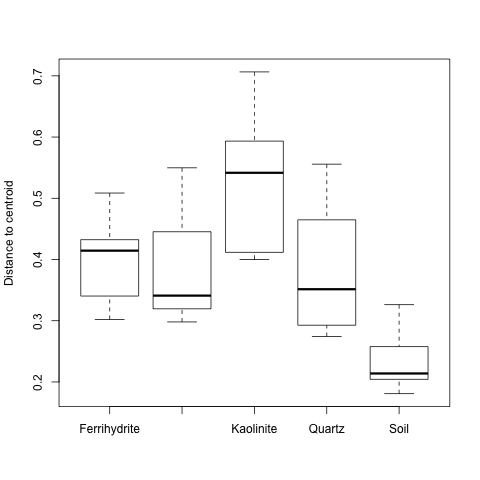

In [10]:
%%R
df = as(sample_data(physeq), "data.frame")
d = distance(physeq, method = "bray")
sampdat = sample_data(physeq)
groups = as.factor(sampdat$Trtmt)
x = betadisper(d, groups)
boxplot(x, ylab = "Distance to centroid")
anova(x)
TukeyHSD(x, ordered = FALSE, conf.level = 0.95)
# Performing test of beta dispersion - the permanova/adonis test requires that groups have similar dispersion.
# This doesn't look outrageously bad here. Some worry re. Kaolinite, as expected, and soils look tight too.

In [23]:
%%R
df = as(sample_data(physeq), "data.frame")
d = distance(physeq, method = "bray")

d.adonis = adonis(d ~ sample_data(physeq)$Month + sample_data(physeq)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(physeq)$Month + sample_data(physeq)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
sample_data(physeq)$Month  1    0.2351 0.23507  1.5134 0.01728  0.080 .  
sample_data(physeq)$Trtmt  4    5.2909 1.32272  8.5157 0.38895  0.001 ***
Residuals                 52    8.0770 0.15533         0.59377           
Total                     57   13.6029                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


There is a significant effect of both month and treatment, across samples

In [8]:
%%R
physeq.QS = subset_samples(physeq, Trtmt == c("Soil","Quartz"))
physeq.FS = subset_samples(physeq, Trtmt == c("Soil","Ferrihydrite"))
physeq.QF = subset_samples(physeq, Trtmt == c("Quartz","Ferrihydrite"))

In [8]:
%%R
ps = physeq.QS
df = as(sample_data(ps), "data.frame")
d = distance(ps, method = "bray")

d.adonis = adonis(d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
sample_data(ps)$Month  1   0.09045 0.09045  0.8509 0.03781  0.479    
sample_data(ps)$Trtmt  1   1.02607 1.02607  9.6527 0.42894  0.001 ***
Residuals             12   1.27558 0.10630         0.53325           
Total                 14   2.39211                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [9]:
%%R
ps = physeq.FS
df = as(sample_data(ps), "data.frame")
d = distance(ps, method = "bray")

d.adonis = adonis(d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
sample_data(ps)$Month  1   0.17345 0.17345  1.5799 0.05869  0.159    
sample_data(ps)$Trtmt  1   1.24509 1.24509 11.3409 0.42127  0.001 ***
Residuals             14   1.53703 0.10979         0.52005           
Total                 16   2.95557                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [9]:
%%R
ps = physeq.QF
df = as(sample_data(ps), "data.frame")
d = distance(ps, method = "bray")

d.adonis = adonis(d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
sample_data(ps)$Month  1   0.20510 0.20510  1.2920 0.07337  0.149    
sample_data(ps)$Trtmt  1   0.52668 0.52668  3.3178 0.18840  0.001 ***
Residuals             13   2.06371 0.15875         0.73823           
Total                 15   2.79549                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Testing to see if there is a difference between Months 2 and 2.5

In [24]:
%%R
physeq.later = subset_samples(physeq, Month!=2.0)
physeq.later = subset_samples(physeq.later, Trtmt!="Heavy Fraction")
# Removing this because it doesn't exist in both timepoints
# physeq.later = subset_samples(physeq.later, Trtmt!="Kaolinite")
# Removing this because we know it's more extreme than other samples - test if it makes a difference

In [25]:
%%R
df = as(sample_data(physeq.later), "data.frame")
d = distance(physeq.later, method = "bray")

d.adonis = adonis(d ~ sample_data(physeq.later)$Month + sample_data(physeq.later)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(physeq.later)$Month + sample_data(physeq.later)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                                Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
sample_data(physeq.later)$Month  1    0.2258 0.22583  1.4385 0.02196  0.117    
sample_data(physeq.later)$Trtmt  3    3.7779 1.25931  8.0220 0.36739  0.001 ***
Residuals                       40    6.2793 0.15698         0.61064           
Total                           44   10.2830                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


#### Under Unifrac, there is a significant effect  of time on the samples (2 vs 2.5 months). This remains even if we exclude kaolinite...
#### However, under Bray, there are not significant effects of Month.